In [1]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from bisect import bisect_left
from tqdm import tqdm


In [2]:
sys.path.append('../../../../nadavp/new_trap/Tools/StatFramework/')
from likelihood_calculator import likelihood_analyser

### Load data

In [15]:
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams["font.size"]=(36)

In [3]:
Year = "2019"
Month = "11"
Day = "14"
BeadNumber =1
folder_basic = r"/home/data_transfer/data_from_windows/"+ Year + Month + Day + "/Bead"+str(BeadNumber)

In [21]:
folder_shaking = "/Shaking/Shaking24/" # with shield
folder = folder_basic + folder_shaking

In [80]:
folder_shaking = "/Shaking/Shaking25/" # no shield
folder = folder_basic + folder_shaking

In [15]:
folder_shaking = "/Shaking/Shaking28/" # no shaking no shield
folder = folder_basic + folder_shaking

In [81]:
files = load_dir_sorted(folder, file_prefix = 'Shaking', max_file=10)

1000  files in folder
10  files loaded


### X2 only

In [82]:
lc_i = likelihood_analyser.LikelihoodAnalyser()

Data overall time:  10.0  sec.
Bandpass filter ON. Bandwidth:  2 Hz
bandpass time:  0.001987934112548828


/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


minimization time:  0.6542203426361084
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | A    |   9.828   |   0.006   |            |            |    0    |   100   |       |
| 1 | f    |    13     |    10     |            |            |         |         |  yes  |
| 2 | phi  |   2.753   |   0.001   |            |            |-6.28319 | 6.28319 |       |
------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


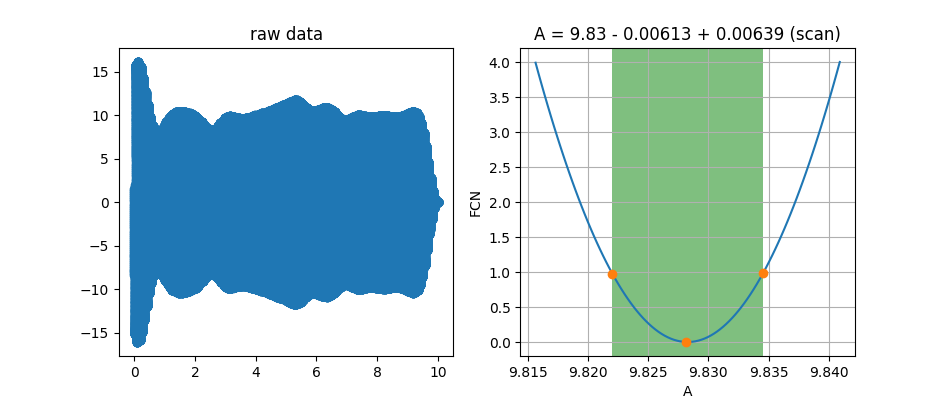

reduced chi2:  2.35063485511715


In [160]:
bdf_tmp = files[2]
sig_x2 = bdf_tmp.x2*50000
sig_x3 = bdf_tmp.x3/3
freq =13
fit_kwargs = {'A': 1, 'f': freq, 'phi': 0,
              'error_A': 1, 'error_f': 10, 'error_phi': 0.5, 'errordef': 1,
              'limit_phi': [-2 * np.pi, 2 * np.pi], 'limit_A': [0,100],
              'print_level': 0, 'fix_f': True, 'fix_phi': False}

empirical_rms = 1
m1 = lc_i.find_mle_sin(sig_x2, drive_freq=freq, noise_rms=empirical_rms, bandwidth=2, plot=True,
                       suppress_print=False, **fit_kwargs)

In [151]:
## 10 datasets x2 only fit
fit_kwargs = {'A': 1, 'f': freq, 'phi': 0,
              'error_A': 1, 'error_f': 10, 'error_phi': 0.5, 'errordef': 1,
              'limit_phi': [-2 * np.pi, 2 * np.pi], 'limit_A': [0,100],
              'print_level': 0, 'fix_f': True, 'fix_phi': False}
empirical_rms = 1
m1_shaking_no_shield = [lc_i.find_mle_sin(bdf_.x2*50000, drive_freq=freq, noise_rms=empirical_rms, bandwidth=2, plot=False,
                       suppress_print=True, **fit_kwargs) for bdf_ in files]

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


#### X3 only

In [161]:
## 10 datasets x3 only fit
fit_kwargs = {'A': 1, 'f': freq, 'phi': 0,
              'error_A': 1, 'error_f': 10, 'error_phi': 0.5, 'errordef': 1,
              'limit_phi': [-2 * np.pi, 2 * np.pi], 'limit_A': [0,100],
              'print_level': 0, 'fix_f': True, 'fix_phi': False}
empirical_rms = 1
m1_shaking_no_shield_x3 = [lc_i.find_mle_sin(bdf_.x3/3, drive_freq=freq, noise_rms=empirical_rms, bandwidth=2, plot=False,
                       suppress_print=True, **fit_kwargs) for bdf_ in files]

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [162]:
amps = [m1_.values[0] for m1_ in m1_shaking_no_shield]
phases = [m1_.values[2] for m1_ in m1_shaking_no_shield]

amps_x3 = [m1_.values[0] for m1_ in m1_shaking_no_shield_x3]
phases_x3 = [m1_.values[2] for m1_ in m1_shaking_no_shield_x3]

<IPython.core.display.Javascript object>


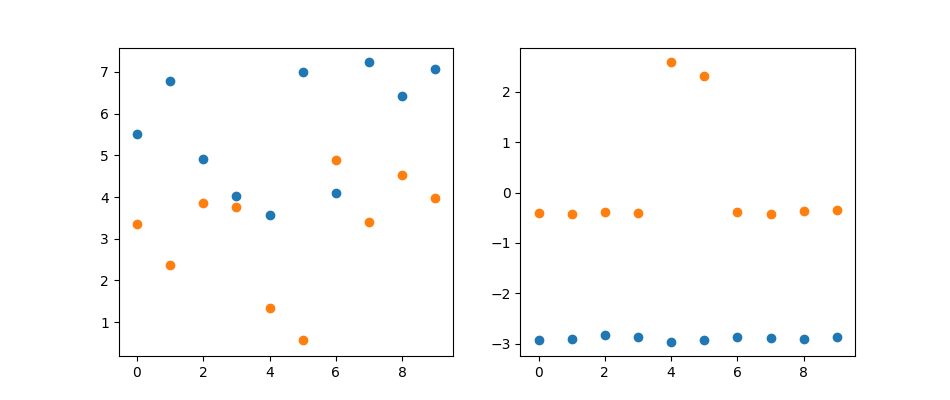

In [163]:
_,ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].scatter(range(10),amps)
ax[0].scatter(range(10),amps_x3)

ax[1].scatter(range(10),phases)
ax[1].scatter(range(10),phases_x3)

### Discriminator parameters

In [88]:
#discharge file_lists
file_list = []
x_discharge_files = range(42,46)
file_list.append(x_discharge_files)
y_discharge_files = range(47,51)
# file_list.append(y_discharge_files)
z_discharge_files = range(52,56)
# file_list.append(z_discharge_files)

Year = "2019"
Month = "11"
Day = "14"
BeadNumber =1
folder = r"/home/data_transfer/data_from_windows/"+ Year + Month + Day

In [89]:
BDF_cal_x = []
for i in range(42,46):
    fname = folder+"/Bead"+str(BeadNumber)+"/Discharge"+"/Discharge_%d.h5" %i
    BDF_cal_x.append(BeadDataFile.BeadDataFile(fname))

func_t = A * np.sin(2 * np.pi * f * self.data_x + phi)  # function to minimize
func_t2 = A * A2 * np.sin(2 * np.pi * f2 * self.data_x + phi + delta_phi)  # function to minimize

Data overall time:  10.0  sec.
Bandpass filter ON. Bandwidth:  2 Hz
bandpass time:  0.002967357635498047


/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


minimization time:  3.0616791248321533
-----------------------------------------------------------------------------------------------
|   | Name      |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-----------------------------------------------------------------------------------------------
| 0 | A         |  123.328  |   0.006   |            |            |    0    |  10000  |       |
| 1 | A2        |   0.342   |   0.000   |            |            |    0    |  1000   |       |
| 2 | f         |    151    |    10     |            |            |         |         |  yes  |
| 3 | f2        |    151    |    10     |            |            |         |         |  yes  |
| 4 | phi       | -1.583E-1 |  0.001E-1 |            |            |-6.28319 | 6.28319 |       |
| 5 | delta_phi | 0.528E-1  | 0.002E-1  |            |            |-3.14159 | 3.14159 |       |
-----------------------------------------------------------------------------------------------


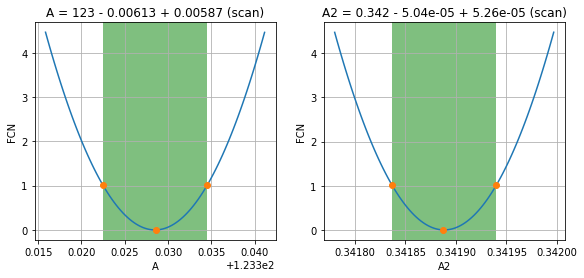

reduced chi2:  132.40008549142638


In [90]:
bdf_tmp = BDF_cal_x[3]
sig_x2 = bdf_tmp.x2*50000
sig_x3 = bdf_tmp.x3/3
freq = 151
fit_kwargs = {'A': 10, 'f': freq, 'phi': 0, 'A2': 2, 'f2': freq, 'delta_phi': 0,
              'error_A': 2, 'error_f': 10, 'error_phi': 0.5, 'errordef': 1,
              'error_A2': 2, 'error_f2': 10, 'error_delta_phi': 0.1,
              'limit_phi': [-2*np.pi, 2 * np.pi],'limit_delta_phi': [-1*np.pi, 1*np.pi],
              'limit_A': [0,10000], 'limit_A2': [0,1000],
              'print_level': 0, 'fix_f': True, 'fix_phi': False, 'fix_f2': True, 'fix_delta_phi': False, 'fix_A2': False}
empirical_rms=1
m1 = lc_i.find_mle_2sin(sig_x2, sig_x3, drive_freq=freq, noise_rms=empirical_rms, noise_rms2=empirical_rms,
                        bandwidth=2, plot=True, suppress_print=False, **fit_kwargs)

/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


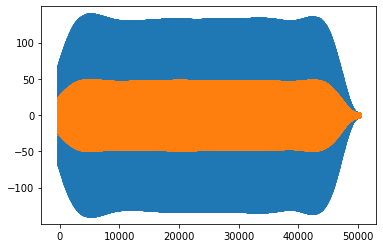

In [91]:
_,ax = plt.subplots()
ax.scatter(range(50000), bdf_tmp.response_at_freq2('x',drive_freq=151)*50000)
ax.scatter(range(50000), bdf_tmp.response_at_freq3('x',drive_freq=151)/3)

In [164]:
## 10 datasets x3 only fit
fit_kwargs = {'A': 1, 'f': freq, 'phi': 0, 'A2': 0.342, 'f2': freq, 'delta_phi': 0,
              'error_A': 1, 'error_f': 10, 'error_phi': 0.5, 'errordef': 1,
              'error_A2': 0.1, 'error_f2': 10, 'error_delta_phi': 0.1,
              'limit_phi': [-2*np.pi, 2 * np.pi],'limit_delta_phi': [-1*np.pi, 1*np.pi],
              'limit_A': [0,100], 'limit_A2': [0,100],
              'print_level': 0, 'fix_f': True, 'fix_phi': False, 'fix_f2': True, 'fix_delta_phi': True, 'fix_A2': True}

empirical_rms = 1
m1_shaking_no_shield_x2x3 = [lc_i.find_mle_2sin(bdf_.x2*50000, bdf_.x3/3, drive_freq=freq, noise_rms=empirical_rms, 
                                             noise_rms2=empirical_rms, bandwidth=2, plot=False, suppress_print=False, **fit_kwargs) for bdf_ in files]

Data overall time:  10.0  sec.
Bandpass filter ON. Bandwidth:  2 Hz
bandpass time:  0.0039980411529541016


/home/analysis_user/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


minimization time:  1.1212060451507568
-----------------------------------------------------------------------------------------------
|   | Name      |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-----------------------------------------------------------------------------------------------
| 0 | A         |   7.813   |   0.006   |            |            |    0    |   100   |       |
| 1 | A2        |   0.34    |   0.10    |            |            |    0    |   100   |  yes  |
| 2 | f         |    13     |    10     |            |            |         |         |  yes  |
| 3 | f2        |    13     |    10     |            |            |         |         |  yes  |
| 4 | phi       |   2.736   |   0.001   |            |            |-6.28319 | 6.28319 |       |
| 5 | delta_phi |   0.00    |   0.10    |            |            |-3.14159 | 3.14159 |  yes  |
-----------------------------------------------------------------------------------------------
r

minimization time:  1.1053156852722168
-----------------------------------------------------------------------------------------------
|   | Name      |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-----------------------------------------------------------------------------------------------
| 0 | A         |   8.901   |   0.006   |            |            |    0    |   100   |       |
| 1 | A2        |   0.34    |   0.10    |            |            |    0    |   100   |  yes  |
| 2 | f         |    13     |    10     |            |            |         |         |  yes  |
| 3 | f2        |    13     |    10     |            |            |         |         |  yes  |
| 4 | phi       |   2.698   |   0.001   |            |            |-6.28319 | 6.28319 |       |
| 5 | delta_phi |   0.00    |   0.10    |            |            |-3.14159 | 3.14159 |  yes  |
-----------------------------------------------------------------------------------------------
r

In [165]:
amps_x2x3 = [m1_.values[0] for m1_ in m1_shaking_no_shield_x2x3]
phases_x2x3 = [m1_.values[4] for m1_ in m1_shaking_no_shield_x2x3]

<IPython.core.display.Javascript object>


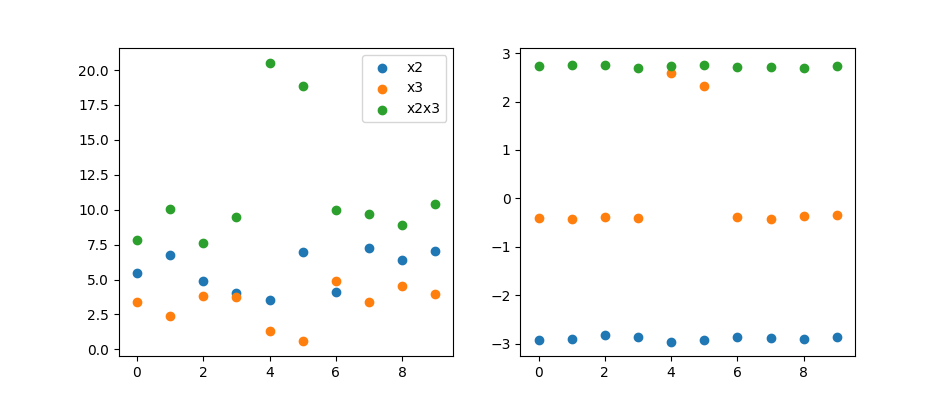

In [166]:
_,ax = plt.subplots(1,2,figsize=(9.5,4))
ax[0].scatter(range(10),amps, label='x2')
ax[0].scatter(range(10),amps_x3, label='x3')
ax[0].scatter(range(10),amps_x2x3, label='x2x3')
ax[0].legend()


ax[1].scatter(range(10),phases)
ax[1].scatter(range(10),phases_x3)
ax[1].scatter(range(10),phases_x2x3)


<IPython.core.display.Javascript object>


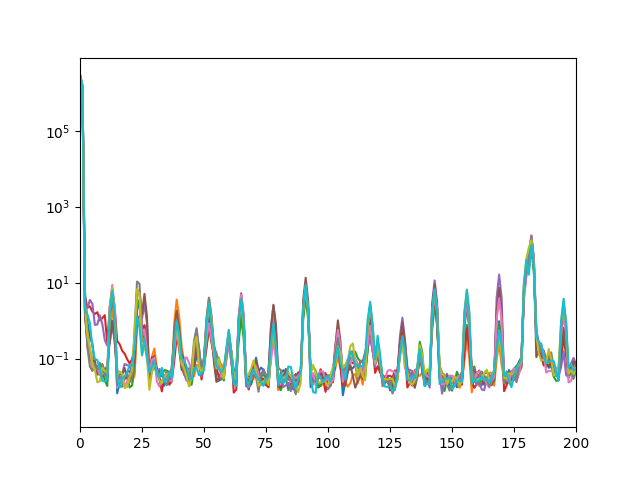

In [138]:
_,ax = plt.subplots()
for file_ in files:
    xpsd, freqs = matplotlib.mlab.psd(file_.x3/3, Fs = 5000, NFFT = 5000)
    ax.semilogy(freqs,xpsd)
    ax.set(xlim=(0,200))

In [137]:
%matplotlib notebook